In [17]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 19.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [55]:
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

sns.set_context('poster')
sns.set(rc={'figure.figsize': (14., 8.)})
sns.set_style('whitegrid')

# Análisis
# ==============================================================================
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import backtesting_forecaster


In [2]:
temperatura = pd.read_excel('../data/AEMET_temperature_data_2014-2020.xlsx', parse_dates=[0])

In [3]:
temperatura

,Unnamed: 0,T (ºC)
0,2014-01-01,11.48750
1,2014-01-02,13.08750
2,2014-01-03,14.43125
3,2014-01-04,11.98125
4,2014-01-05,10.94375
...,...,...
2552,2020-12-27,6.55625
2553,2020-12-28,8.61875
2554,2020-12-29,7.54375
2555,2020-12-30,7.00000


In [5]:
temperatura.rename(columns={'Unnamed: 0': 'date', 'T (ºC)': 'Temperature'}, inplace=True)
temperatura.set_index('date',inplace=True)
temperatura.head()

,Temperature
date,
2014-01-01,11.48750
2014-01-02,13.08750
2014-01-03,14.43125
2014-01-04,11.98125
2014-01-05,10.94375


In [7]:
temperatura.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2557 entries, 2014-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  2557 non-null   float64
dtypes: float64(1)
memory usage: 40.0 KB


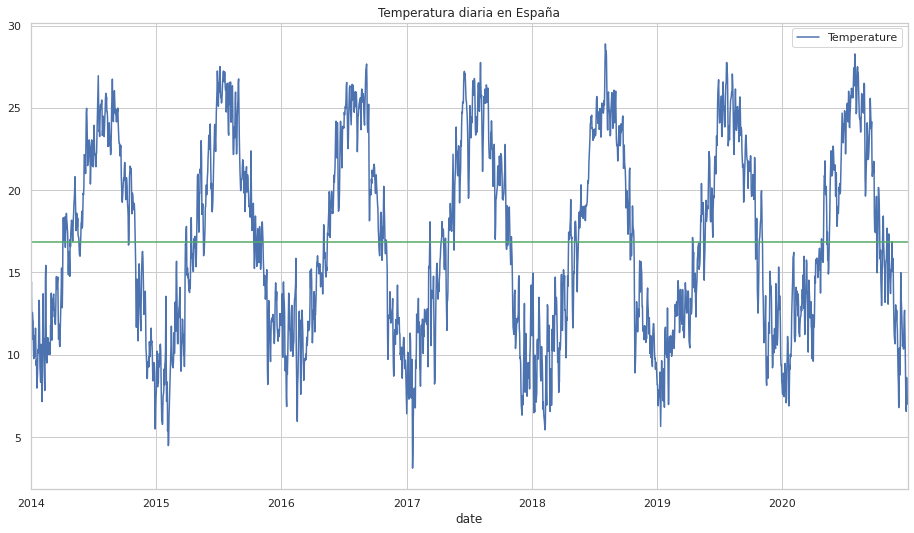

In [12]:
temperatura.plot();
plt.title("Temperatura diaria en España")
plt.axhline(temperatura.Temperature.mean(), c="g", label="media");

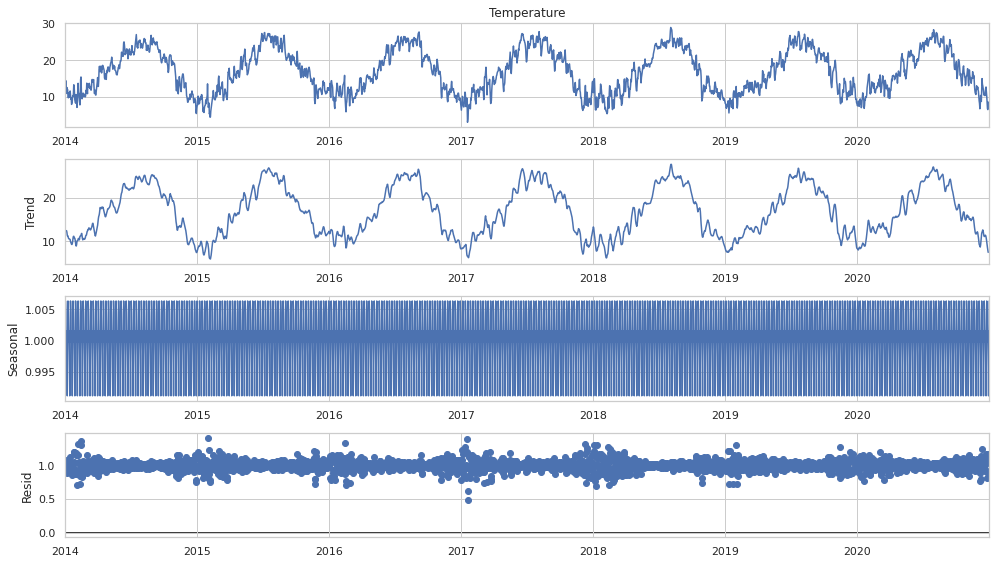

In [38]:
result = seasonal_decompose(temperatura.Temperature, 
                            model ='multiplicative')
result.plot();

Realizamos un test estadístico con adfuller para verificar que los datos de temperatura son estacionarios. Este nos dará un p-valor que si es menor que 0,05 nos permitirá rechazar la hipótesis nula de que los datos NO son estacionarios al 95%

In [15]:
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(temperatura.Temperature)

1. ADF :  -3.1119405128442215
2. P-Value :  0.025682064133844624
3. Num Of Lags :  27
4. Num Of Observations Used For ADF Regression: 2529
5. Critical Values :
	 1% :  -3.432938355012086
	 5% :  -2.8626835272597217
	 10% :  -2.567378742868999


Podemos rechazar la hipótesis nula.Los valores son estacionarios.

Por lo tanto podremos usar un modelo ARIMA (auto regresion + integración + medias moviles) para predecir la temperatura a futuro.

In [20]:
stepwise_fit = auto_arima(temperatura.Temperature, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7396.377, Time=4.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16249.617, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7740.265, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=13161.139, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21985.674, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=7495.372, Time=1.70 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=7510.139, Time=1.24 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=7390.147, Time=5.53 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=7410.071, Time=4.35 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.42 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=7392.719, Time=7.88 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=7390.396, Time=5.72 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=7393.158, Time=8.14 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=7393.505, Time=8.74 sec
 ARIMA(3,0,2)(0,0,0)[0]            

In [21]:

train=temperatura.iloc[:-365]
test=temperatura.iloc[-365:]
print(train.shape,test.shape)

(2192, 1) (365, 1)


In [32]:
model=ARIMA(train['Temperature'],order=(3,0,2))
result=model.fit()
result.summary()

/home/cleonortiz/anaconda3/envs/modelo/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cleonortiz/anaconda3/envs/modelo/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/cleonortiz/anaconda3/envs/modelo/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Temperature   No. Observations:                 2192
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -3159.942
Date:                Tue, 01 Mar 2022   AIC                           6333.885
Time:                        21:15:53   BIC                           6373.733
Sample:                    01-01-2014   HQIC                          6348.448
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9311      2.231      7.141      0.000      11.558      20.304
ar.L1          1.7787      0.052     34.513      0.000       1.678       1.880
ar.L2         -0.9444      0.097     -9.751      0.000      -1.134      -0.755
ar.L3          0.1635      0.053      3.058      0.002       0.059       0.268
ma.L1         -0.5484      0.050    -10.951      0.000      -0.647      -0.450
ma.L2         -0.2254      0.053     -4.252      0.000      -0.329      -0.122
sigma2         1.0445      0.025     42.518      0.000       0.996       1.093
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               240.74
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.24
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

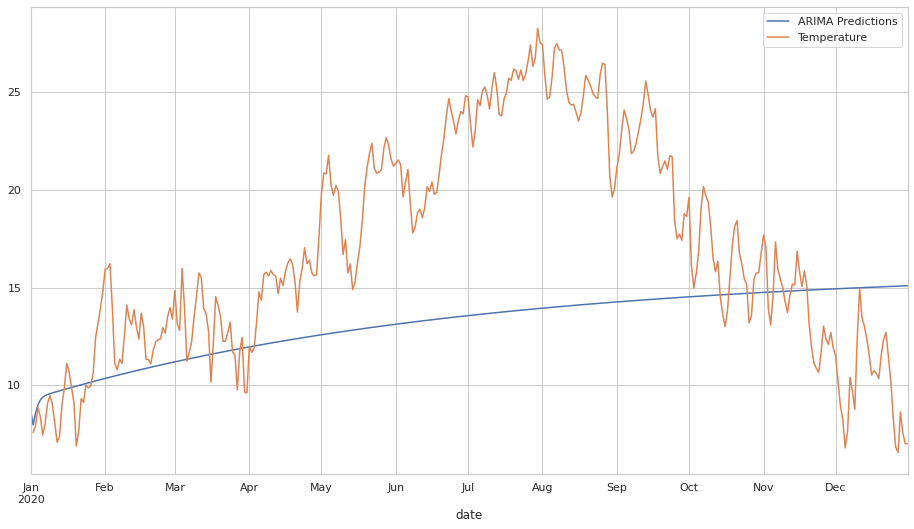

In [33]:
start='2020-01-01'
end='2020-12-31'
pred=result.predict(start,end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Temperature'].plot(legend=True)

In [62]:
infer_ = pd.infer_freq(train.index)
train.index.freq = infer_
infer_ = pd.infer_freq(test.index)
test.index.freq = infer_

In [63]:
train.index

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2019-12-23', '2019-12-24', '2019-12-25', '2019-12-26',
               '2019-12-27', '2019-12-28', '2019-12-29', '2019-12-30',
               '2019-12-31', '2020-01-01'],
              dtype='datetime64[ns]', name='date', length=2192, freq='D')

In [64]:
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge()),
                lags      = 30
             )

forecaster.fit(y=train['Temperature'])
forecaster


ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2020-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-03-01 22:43:09 
Last fit date: 2022-03-01 22:43:10 
Skforecast version: 0.4.2 

In [81]:
fin_train= '2018-12-31'

In [85]:
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = temperatura.Temperature,
                            initial_train_size = len(temperatura.loc[:fin_train]),
                            steps      = 1, #para predecir el precio del siguiente dia
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 1826
Number of observations used for backtesting: 731
    Number of folds: 731
    Number of steps per fold: 1

Data partition in fold: 0
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-01-01 00:00:00 -- 2019-01-01 00:00:00
Data partition in fold: 1
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-01-02 00:00:00 -- 2019-01-02 00:00:00
Data partition in fold: 2
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-01-03 00:00:00 -- 2019-01-03 00:00:00
Data partition in fold: 3
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-01-04 00:00:00 -- 2019-01-04 00:00:00
Data partition in fold: 4
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-01-05 00:00:00 -- 2019-01-05 00:00:00
Data partition in fold: 5
 

Data partition in fold: 329
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-11-26 00:00:00 -- 2019-11-26 00:00:00
Data partition in fold: 330
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-11-27 00:00:00 -- 2019-11-27 00:00:00
Data partition in fold: 331
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-11-28 00:00:00 -- 2019-11-28 00:00:00
Data partition in fold: 332
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-11-29 00:00:00 -- 2019-11-29 00:00:00
Data partition in fold: 333
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-11-30 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 334
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-12-01 00:00:00 -- 2019-12-01 00:00:00
Data partition in fold: 335
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2019-12-02 00:00:00 -

    Validation: 2020-12-27 00:00:00 -- 2020-12-27 00:00:00
Data partition in fold: 727
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2020-12-28 00:00:00 -- 2020-12-28 00:00:00
Data partition in fold: 728
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2020-12-29 00:00:00 -- 2020-12-29 00:00:00
Data partition in fold: 729
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2020-12-30 00:00:00 -- 2020-12-30 00:00:00
Data partition in fold: 730
    Training:   2014-01-01 00:00:00 -- 2018-12-31 00:00:00
    Validation: 2020-12-31 00:00:00 -- 2020-12-31 00:00:00



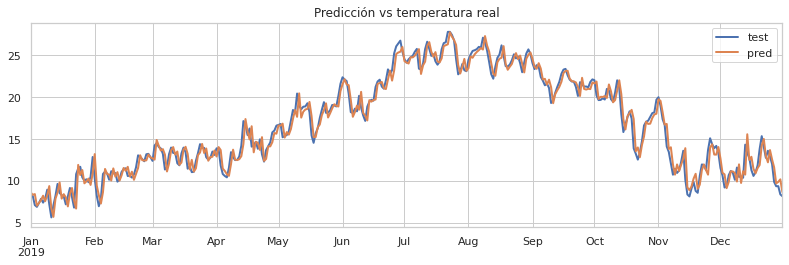

In [86]:
fig, ax = plt.subplots(figsize=(12, 3.5))
temperatura.loc[predicciones.index[:365], 'Temperature'].plot(ax=ax, linewidth=2, label='test')
predicciones[:365].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs temperatura real')
ax.legend();

In [79]:
print(f'Error backtest: {metrica}')

Error backtest: [0.80619825]


In [80]:
predicciones

,pred
2020-01-01,8.918111
2020-01-02,8.017541
2020-01-03,8.274798
2020-01-04,8.398593
2020-01-05,9.317442
...,...
2020-12-27,7.142950
2020-12-28,7.524512
2020-12-29,9.564638
2020-12-30,7.506682


In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();